In [57]:
import pyro
import torch
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import ExitStack
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointObservation,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)
from causal_pyro.dynamical.ops import State, Trajectory

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

In [58]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        S = pyro.deterministic("S", X.S)
        I = pyro.deterministic("I", X.I)
        R = pyro.deterministic("R", X.R)
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs, "S": S, "I": I, "R": R}

# Generate synthetic data from an SIR model

In [59]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))
time_period = torch.linspace(0, 3, steps=21)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true =  torch.tensor(0.5)
sir = SimpleSIRDynamics(beta_true, gamma_true)
sir_traj = simulate(sir, init_state, time_period)

### Plot the simulated trajectories from SIR model

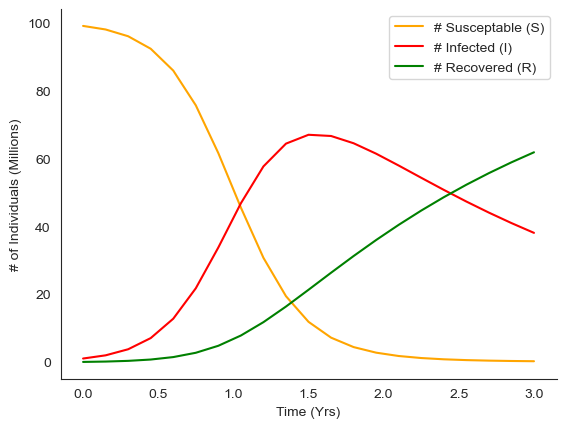

In [60]:
sns.lineplot(x=time_period, y=sir_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [61]:
obs_time_period = torch.arange(0, 1.51, 1/52) # collect data every week for past 1.5yrs
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[time_ix] = [obs_time_period[time_ix], sir.observation(sir_obs_traj[time_ix])]

In [62]:
test_kit_sales = torch.stack([data[time_ix][1]["test_kit_sales"] for time_ix in range(N_obs)])
I_obs = torch.stack([data[time_ix][1]["I_obs"] for time_ix in range(N_obs)])
R_obs = torch.stack([data[time_ix][1]["R_obs"] for time_ix in range(N_obs)])

Text(0, 0.5, 'Observed # Recovered (Millions)')

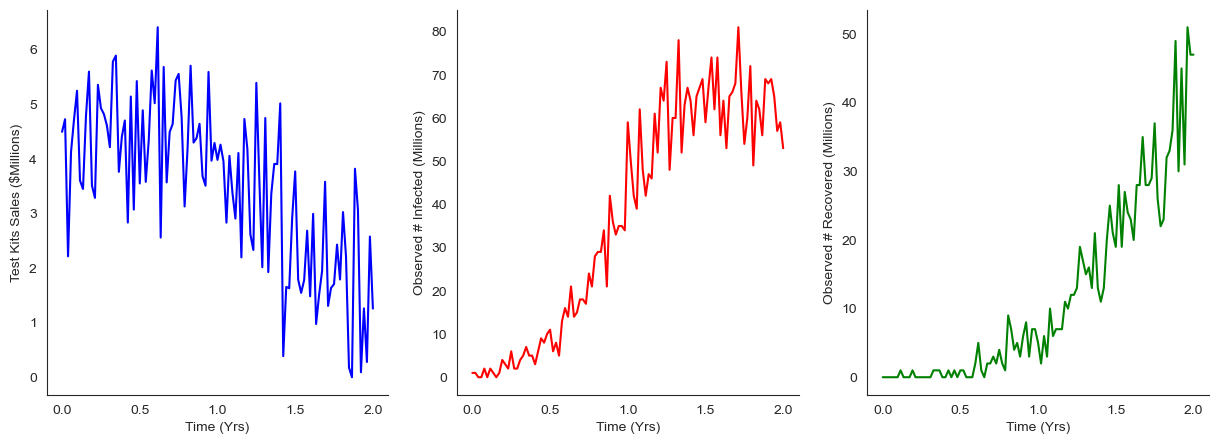

In [63]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.lineplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

# Perform Inference!

In [64]:
# We place uniform priors on the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir

def conditioned_sir(data, init_state, tspan):
    sir = model()
    observation_managers = []
    for obs in data.values():
        obs_time = obs[0].item()
        obs_data = obs[1]
        observation_managers.append(PointObservation(obs_time, obs_data))
    with SimulatorEventLoop():
        with ExitStack() as stack:
            for manager in observation_managers:
                stack.enter_context(manager)
            traj = simulate(sir, init_state, tspan)
    return traj

In [65]:
guide = AutoMultivariateNormal(conditioned_sir)
# set up the optimizer
adam = pyro.optim.Adam({"lr": 0.03})

# setup the inference algorithm
svi = SVI(conditioned_sir, guide, adam, loss=Trace_ELBO())

n_steps = 200
# do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(data, init_state, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))
    guide_median = guide.median()
    print("beta post. median est: %.4f, gamma post. median est: %.4f" % (guide_median['beta'].item(), guide_median['gamma'].item()))
        

[iteration 0001] loss: 45.1735
beta Est: 0.4849, gamma est: 0.4859
[iteration 0002] loss: 45.8122
beta Est: 0.4774, gamma est: 0.4784
[iteration 0003] loss: 46.0576
beta Est: 0.4699, gamma est: 0.4709
[iteration 0004] loss: 44.7718
beta Est: 0.4625, gamma est: 0.4634
[iteration 0005] loss: 44.5504
beta Est: 0.4550, gamma est: 0.4560
[iteration 0006] loss: 45.9723
beta Est: 0.4475, gamma est: 0.4486
[iteration 0007] loss: 43.6927
beta Est: 0.4399, gamma est: 0.4412
[iteration 0008] loss: 44.3809
beta Est: 0.4324, gamma est: 0.4338
[iteration 0009] loss: 45.1811
beta Est: 0.4249, gamma est: 0.4265
[iteration 0010] loss: 42.7510
beta Est: 0.4173, gamma est: 0.4192
[iteration 0011] loss: 43.5230
beta Est: 0.4099, gamma est: 0.4120
[iteration 0012] loss: 42.6360
beta Est: 0.4024, gamma est: 0.4049
[iteration 0013] loss: 44.0868
beta Est: 0.3950, gamma est: 0.3979
[iteration 0014] loss: 41.6105
beta Est: 0.3876, gamma est: 0.3909
[iteration 0015] loss: 41.4156
beta Est: 0.3802, gamma est: 0.

# Evaluate the performance of our inference

In [68]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(conditioned_sir, guide=guide, num_samples=100)
samples = predictive(data, init_state, time_period)

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

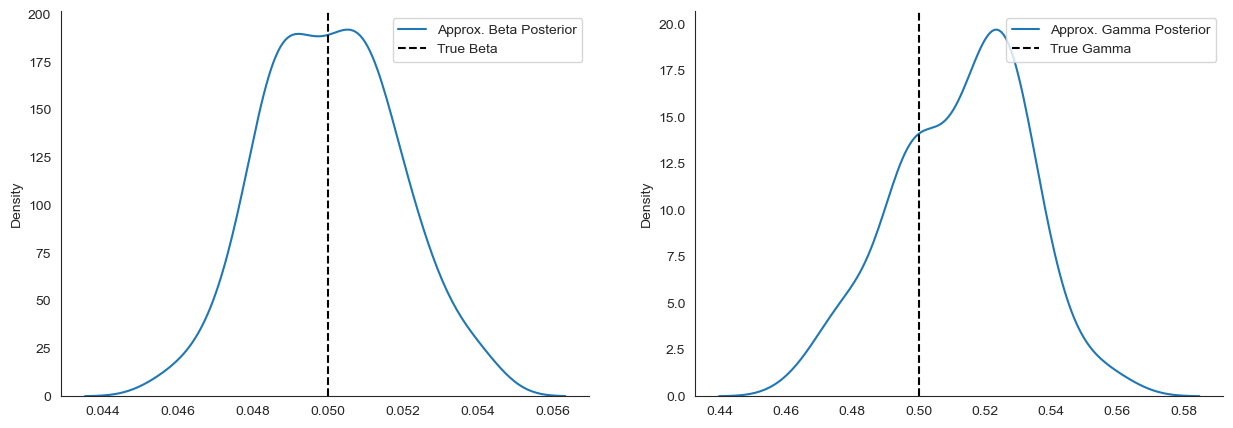

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(samples['beta'], label='Approx. Beta Posterior', ax=ax[0])
ax[0].axvline(beta_true, color='black', label='True Beta', linestyle='--')
sns.despine()
ax[0].legend(loc='upper right')

sns.kdeplot(samples['gamma'], label='Approx. Gamma Posterior', ax=ax[1])
plt.axvline(gamma_true, color='black', label='True Gamma', linestyle='--')
sns.despine()
ax[1].legend(loc='upper right')

### Next, we compare the predictive performance on the held at period betweent $t=2$ and $t=3$ years

In [128]:
### TODO: we should make it easier to get predictions at observation times...approach below is very hacky

# Get predicted values for S, I, and R
S_keys = sorted([key for key in samples.keys() if 'S_' in key], key=lambda x: float(x.split("_")[1]))
I_keys = sorted([key for key in samples.keys() if ('I_' in key) and ('obs' not in key)], key=lambda x: float(x.split("_")[1]))
R_keys = sorted([key for key in samples.keys() if ('R_' in key) and ('obs' not in key)], key=lambda x: float(x.split("_")[1]))

S_pred = torch.stack([samples[key] for key in S_keys])
I_pred = torch.stack([samples[key] for key in I_keys])
R_pred = torch.stack([samples[key] for key in R_keys])

time_points = torch.tensor([float(key.split("_")[1]) for key in S_keys])

In [126]:
len(time_points)

105

In [127]:
S_pred.mean(dim=1).shape[0]


105

In [136]:
S_pred.std(axis=1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

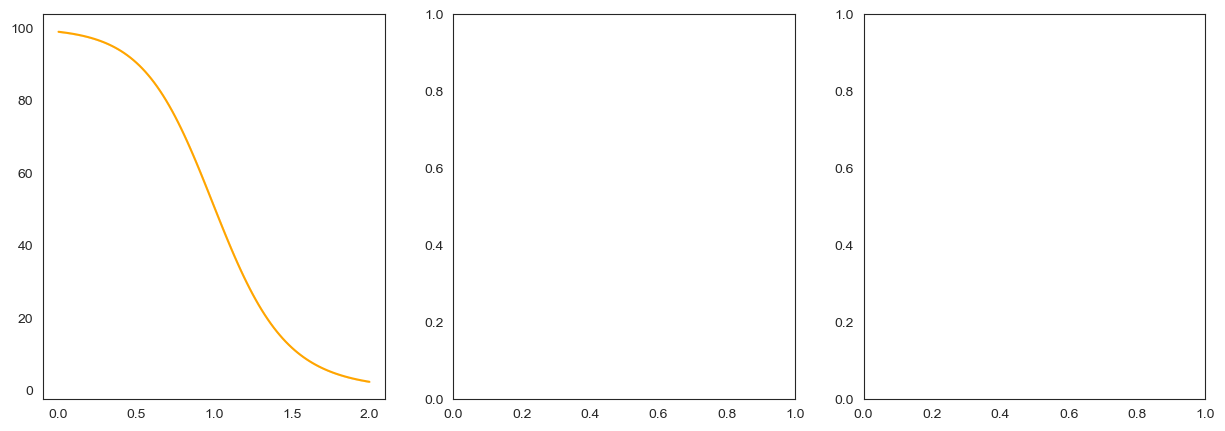

In [131]:
# Plot predicted values for S, I, and R with uncertainty bands
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot predicted susceptible
sns.lineplot(x=time_points, y=S_pred.mean(dim=1), color='orange', ax=ax[0])
ax[0].fill_between(time_points, S_pred.mean(dim=1) - 20*S_pred.std(dim=1), S_pred.mean(dim=1) + 20*S_pred.std(dim=1), alpha=0.2, color='orange')

# sns.despine()
# ax[0].set_xlabel("Time (Yrs)")
# ax[0].set_ylabel("# of Individuals (Millions)")
# ax[0].set_title("Predicted # Susceptible")

# # Plot predicted infected
# sns.lineplot(x=time_period, y=I_pred.mean(dim=0), color='red', ax=ax[1])
# ax[1].fill_between(time_period, I_pred.mean(dim=0) - 2*I_pred.std(dim=0), I_pred.mean(dim=0) + 2*I_pred.std(dim=0), alpha=0.2, color='red')
# sns.despine()
# ax[1].set_xlabel("Time (Yrs)")
# ax[1].set_ylabel("# of Individuals (Millions)")
# ax[1].set_title("Predicted # Infected")

# # Plot predicted recovered
# sns.lineplot(x=time_period, y=R_pred.mean(dim=0), color='green', ax=ax[2])
# ax[2].fill_between(time_period, R_pred.mean(dim=0) - 2*R_pred.std(dim=0), R_pred.mean(dim=0) + 2*R_pred.std(dim=0), alpha=0.2, color='green')
# sns.despine()
# ax[2].set_xlabel("Time (Yrs)")
# ax[2].set_ylabel("# of Individuals (Millions)")
# ax[2].set_title("Predicted # Recovered")

# # Plot observed values for S, I, and R
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# # Plot observed susceptible
# sns.lineplot(x=obs_time_period, y=S_obs, color='orange', ax=ax[0])
# sns.despine()

# # Plot observed infected
# sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
# sns.despine()

# # Plot observed recovered
# sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
# sns.despine()


In [38]:
# Multilevel SIR modeling
# Generate different states for a number of different countries
# Each country conditional on covariates has same dynamics

# Some countries enact different policies at different times
# pool all information together to estimate dynamics

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan